In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from importlib import reload
import warnings
import ot

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
resolution = 1000000
chrom = "chr2"

dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/"

file_list = sorted(glob.glob(f"{dpath}*{resolution}*{chrom}*"))
print(file_list)

population_path = file_list[0]
singlecell_path = file_list[1]

print()

print(f"{population_path=}")
print(f"{singlecell_path=}")

['/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/population_mESC_1000000_chr2.h5ad', '/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/singlecell_mESC_1000000_chr2.h5ad']

population_path='/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/population_mESC_1000000_chr2.h5ad'
singlecell_path='/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/singlecell_mESC_1000000_chr2.h5ad'


# load population

In [3]:
start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
adata

Time taken to read the file: 11.53 seconds
Memory usage: current 0.95 GB, difference +0.95 GB


AnnData object with n_obs × n_vars = 179 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# load single-cell

In [4]:
start_time = time.time()  # Record the start time
bdata = sc.read_h5ad(singlecell_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
bdata

Time taken to read the file: 102.38 seconds
Memory usage: current 2.83 GB, difference +1.88 GB


AnnData object with n_obs × n_vars = 179 × 1865516
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# QC

In [5]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers_iqr(adata.obs['chrom_degree'])
adata.obs[['chrom_bin', 'chrom_degree', 'degree_outlier']].sort_values(by='chrom_degree', ascending=False).head()

,chrom_bin,chrom_degree,degree_outlier
bin_name,,,
chr2:98,98,93161,True
chr2:177,177,3700,True
chr2:174,174,2636,False
chr2:176,176,2293,False
chr2:77,77,2283,False


In [6]:
n_outliers = 2
remove_bins = adata.obs.sort_values(by='chrom_degree', ascending=False).head(n_outliers).index.to_list()
print(f"Removing top {n_outliers} outlier loci: ")
print(remove_bins)

adata = adata[~adata.obs_names.isin(remove_bins), :].copy()
bdata = bdata[~bdata.obs_names.isin(remove_bins), :].copy()

print('done!')

Removing top 2 outlier loci: 
['chr2:98', 'chr2:177']
done!


# Clique-expand

In [7]:
matrix.expand_and_normalize_anndata(adata)
print()
matrix.expand_and_normalize_anndata(bdata)

adata

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.


AnnData object with n_obs × n_vars = 177 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe'

# Centrality measures

In [8]:
ce_centralities = {
    'ce_degree_centrality' : {
        'function' : nx.degree_centrality,
        'weight' : False
    },
    'ce_closeness_centrality' : {
        'function' : nx.closeness_centrality,
        'weight' : False
    },
    'ce_eigenvector_centrality' : {
        'function' : nx.eigenvector_centrality,
        'weight' : True
    },
    'ce_betweenness_centrality' : {
        'function' : nx.betweenness_centrality,
        'weight' : True
    },
    'ce_pagerank' : {
        'function' : nx.pagerank,
        'weight' : True
    },
    
}

obsm_key = 'A_oe'
A = adata.obsm[obsm_key].copy()
# A = A.mask(np.eye(A.shape[0], dtype=bool), 0)

G = nx.from_pandas_adjacency(A)
print(G)

for label, d in ce_centralities.items():
    if d['weight']:
        centrality = d['function'](G, weight='weight')
    else:
        centrality = d['function'](G)
        
    adata.obs[label] = adata.obs.index.map(centrality)
    adata.obs[label] = ut.min_max(adata.obs[label])

adata.obs[list(ce_centralities.keys())].head()

Graph with 177 nodes and 15725 edges


,ce_degree_centrality,ce_closeness_centrality,ce_eigenvector_centrality,ce_betweenness_centrality,ce_pagerank
bin_name,,,,,
chr2:3,1.0,1.000000,0.732730,0.336662,0.754064
chr2:4,0.5,0.497175,0.694866,0.111270,0.711592
chr2:5,1.0,1.000000,1.000000,0.002853,1.000000
chr2:6,1.0,1.000000,0.603946,0.320970,0.617905
chr2:7,1.0,1.000000,0.389607,0.412268,0.433281


Thu Dec 19 10:06:14 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Thu Dec 19 10:06:14 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


([], [])

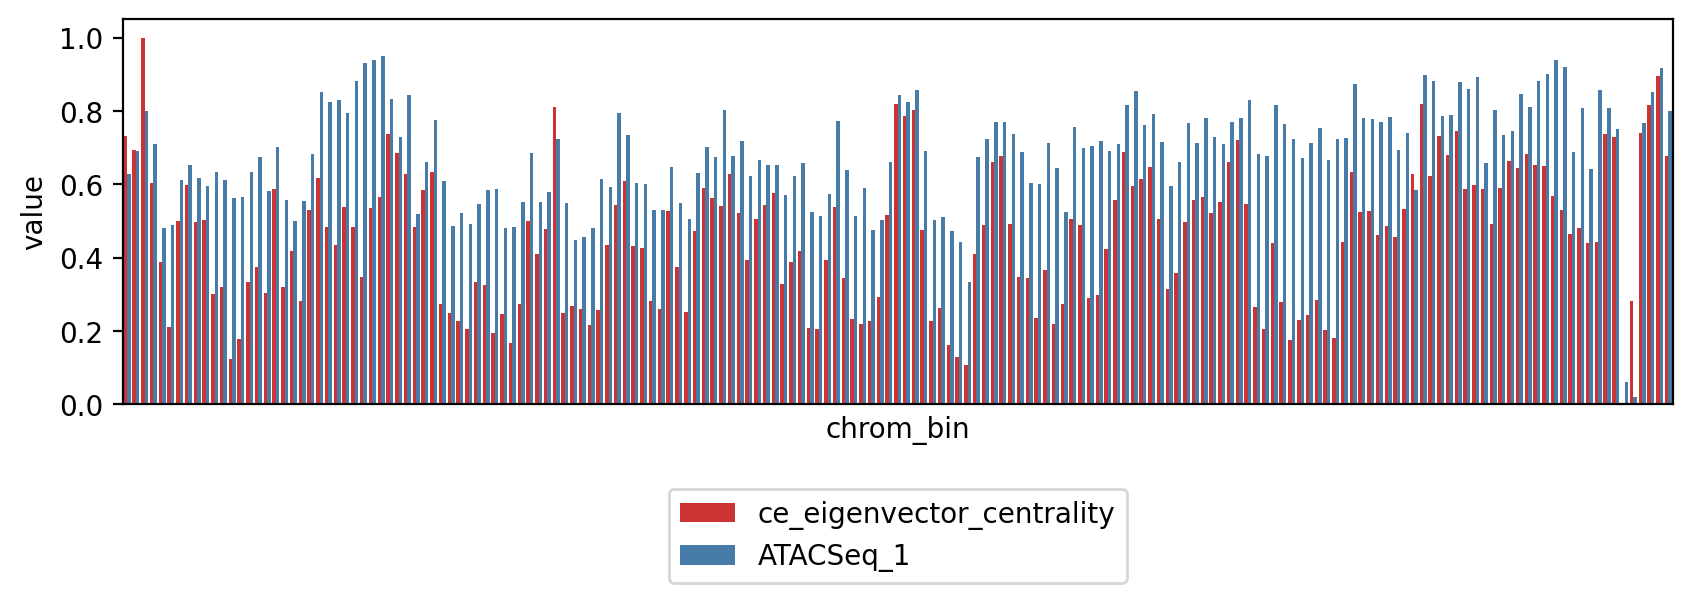

In [9]:
columns = [
    'ce_eigenvector_centrality',
    'ATACSeq_1',
]

pdf = adata.obs.copy()
pdf = pdf[columns + ['chrom_bin']].melt(id_vars='chrom_bin')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 2.5

sns.barplot(
    data=pdf,
    x='chrom_bin',
    y='value',
    hue='variable',
    palette='Set1',
)

sns.move_legend(
    plt.gca(),
    title="",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.5),
)

plt.xticks([])

# higher-order centralities

In [18]:
def balance_incidence_matrix(matrix, reg=0.85):
    """Balances a sparse matrix to be doubly stochastic using Sinkhorn-Knopp.

    Args:
        matrix: A scipy.sparse matrix.
        reg: Regularization parameter for Sinkhorn-Knopp algorithm.

    Returns:
        A balanced sparse matrix.
    """
    start_time = time.time()
    matrix = matrix.toarray()  # Convert to dense array for POT
    a = np.ones(matrix.shape[0]) / matrix.shape[0]  # Uniform row distribution
    b = np.ones(matrix.shape[1]) / matrix.shape[1]  # Uniform column distribution
    balanced_matrix = ot.sinkhorn(a, b, matrix, reg)  # Use input regularization parameter
    end_time = time.time()
    print(f"Balancing matrix took: {end_time - start_time:.2f} seconds")
    return csr_matrix(balanced_matrix)  # Convert back to sparse

In [83]:
# add the principal singular value of the incidence matrix
H = adata.to_df().copy()
print(f"Raw: {H.shape=}")
H = H.T.drop_duplicates().T
print(f"De-duped: {H.shape=}")

node_weight_attr = 'ATACSeq_1' # must be an obs column
node_weights = adata.obs.loc[H.index, node_weight_attr].values


svd = TruncatedSVD(n_components=1, n_iter=10)
adata.obs['singular_vector_1'] = ut.min_max(svd.fit_transform(H))

# hypergraph centralities
hge_functions = {
    'hge_linear_unweighted' : {
        'function' : 'linear',
        'weights' : None,
    },
    'hge_linear_degree_weighted' : {
        'function' : 'linear',
        'weights' : H.sum(axis=1).values,
    },
    'hge_linear_RNA_weighted' : {
        'function' : 'linear',
        'weights' : adata.obs.loc[H.index, 'RNA_2'].values
    },
    'hge_linear_ATAC_weighted' : {
        'function' : 'linear',
        'weights' : adata.obs.loc[H.index, 'ATACSeq_1'].values
    },
    'hge_logexp_unweighted' : {
        'function' : 'log-exp',
        'weights' : None,
    },
    'hge_logexp_degree_weighted' : {
        'function' : 'log-exp',
        'weights' : H.sum(axis=1).values,
    },
    'hge_logexp_RNA_weighted' : {
        'function' : 'log-exp',
        'weights' : adata.obs.loc[H.index, 'RNA_2'].values
    },
    'hge_logexp_ATAC_weighted' : {
        'function' : 'log-exp',
        'weights' : adata.obs.loc[H.index, 'ATACSeq_1'].values
    }
}


hge_centralities = []

for label, d in hge_functions.items():
    start_time = time.time()  # Record start time
    node, edge = central.nonlinear_eigenvector_centrality(
        H,
        function=d['function'],
        node_weights=d['weights'],
    )

    hge_centralities.append(label)
    adata.obs[label] = ut.min_max(node)

    end_time = time.time()  # Record end time
    print(f"{label} calculation took: {end_time - start_time:.2f} seconds")

adata

Raw: H.shape=(177, 186499)
De-duped: H.shape=(177, 46203)
hge_linear_unweighted calculation took: 0.70 seconds
hge_linear_degree_weighted calculation took: 0.70 seconds
hge_linear_RNA_weighted calculation took: 1.21 seconds
hge_linear_ATAC_weighted calculation took: 0.74 seconds
hge_logexp_unweighted calculation took: 0.31 seconds
hge_logexp_degree_weighted calculation took: 6.60 seconds
hge_logexp_RNA_weighted calculation took: 0.37 seconds
hge_logexp_ATAC_weighted calculation took: 0.34 seconds


AnnData object with n_obs × n_vars = 177 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier', 'ce_degree_centrality', 'ce_closeness_centrality', 'ce_eigenvector_centrality', 'ce_betweenness_centrality', 'ce_pagerank', 'singular_value_1', 'hge_linear_centrality', 'hge_log-exp_centrality', 'hge_max_centrality', 'hge_linear_unweighted', 'hge_linear_degree_weighted', 'hge_linear_RNA_weighted', 'hge_linear_ATAC_weighted', 'hge_logexp_unweighted', 'hge_logexp_degree_weighted', 'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted', 'UMAP 1', 'UMAP 2', 'singular_vector_1'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order', 'hge_linear_centrality', 'hge_log-exp_centrality', 'hge_ma

Thu Dec 19 12:06:25 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Thu Dec 19 12:06:25 2024 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


([], [])

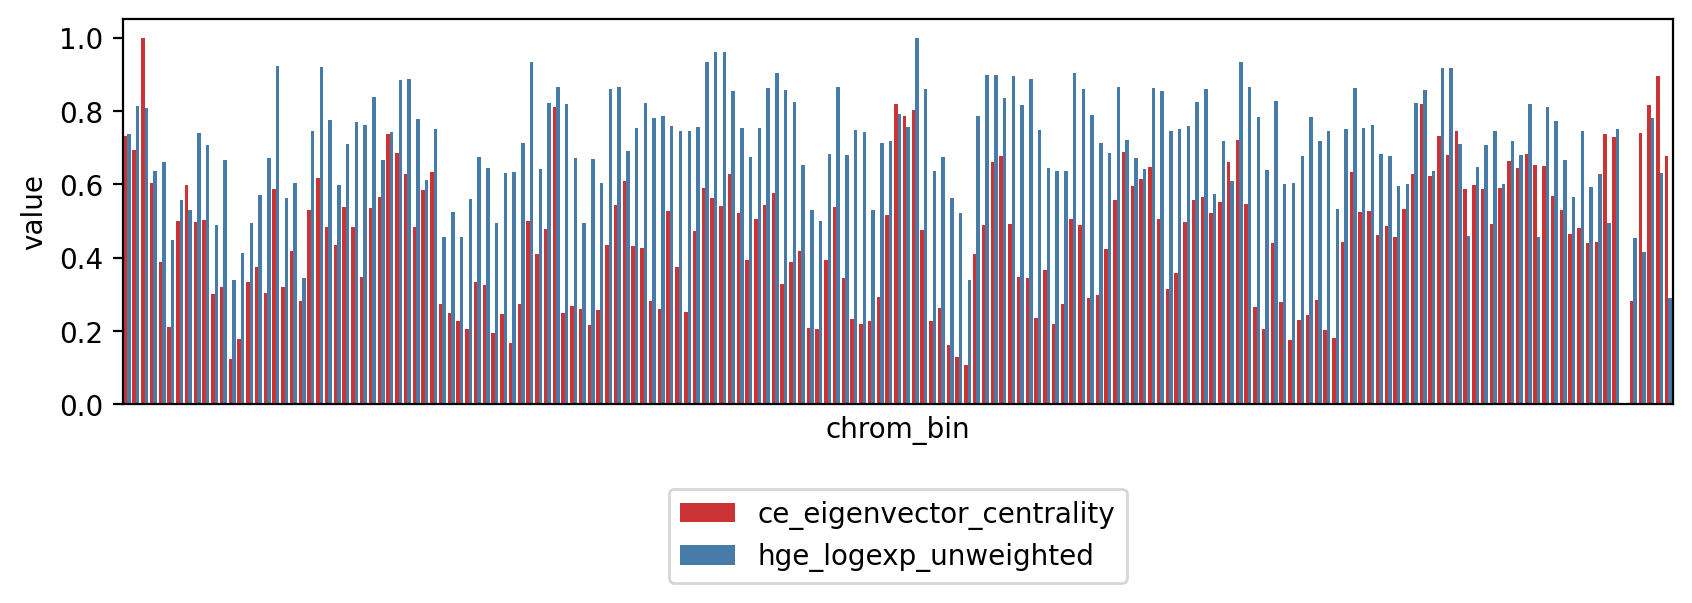

In [84]:
columns = [
    'ce_eigenvector_centrality',
    'hge_logexp_unweighted',
]

pdf = adata.obs.copy()
pdf = pdf[columns + ['chrom_bin']].melt(id_vars='chrom_bin')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 2.5

sns.barplot(
    data=pdf,
    x='chrom_bin',
    y='value',
    hue='variable',
    palette='Set1',
)

sns.move_legend(
    plt.gca(),
    title="",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.5),
)

plt.xticks([])

In [85]:
adata.obs.columns

Index(['bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin',
       'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
       'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4',
       'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier',
       'ce_degree_centrality', 'ce_closeness_centrality',
       'ce_eigenvector_centrality', 'ce_betweenness_centrality', 'ce_pagerank',
       'singular_value_1', 'hge_linear_centrality', 'hge_log-exp_centrality',
       'hge_max_centrality', 'hge_linear_unweighted',
       'hge_linear_degree_weighted', 'hge_linear_RNA_weighted',
       'hge_linear_ATAC_weighted', 'hge_logexp_unweighted',
       'hge_logexp_degree_weighted', 'hge_logexp_RNA_weighted',
       'hge_logexp_ATAC_weighted', 'UMAP 1', 'UMAP 2', 'singular_vector_1'],
      dtype='object')

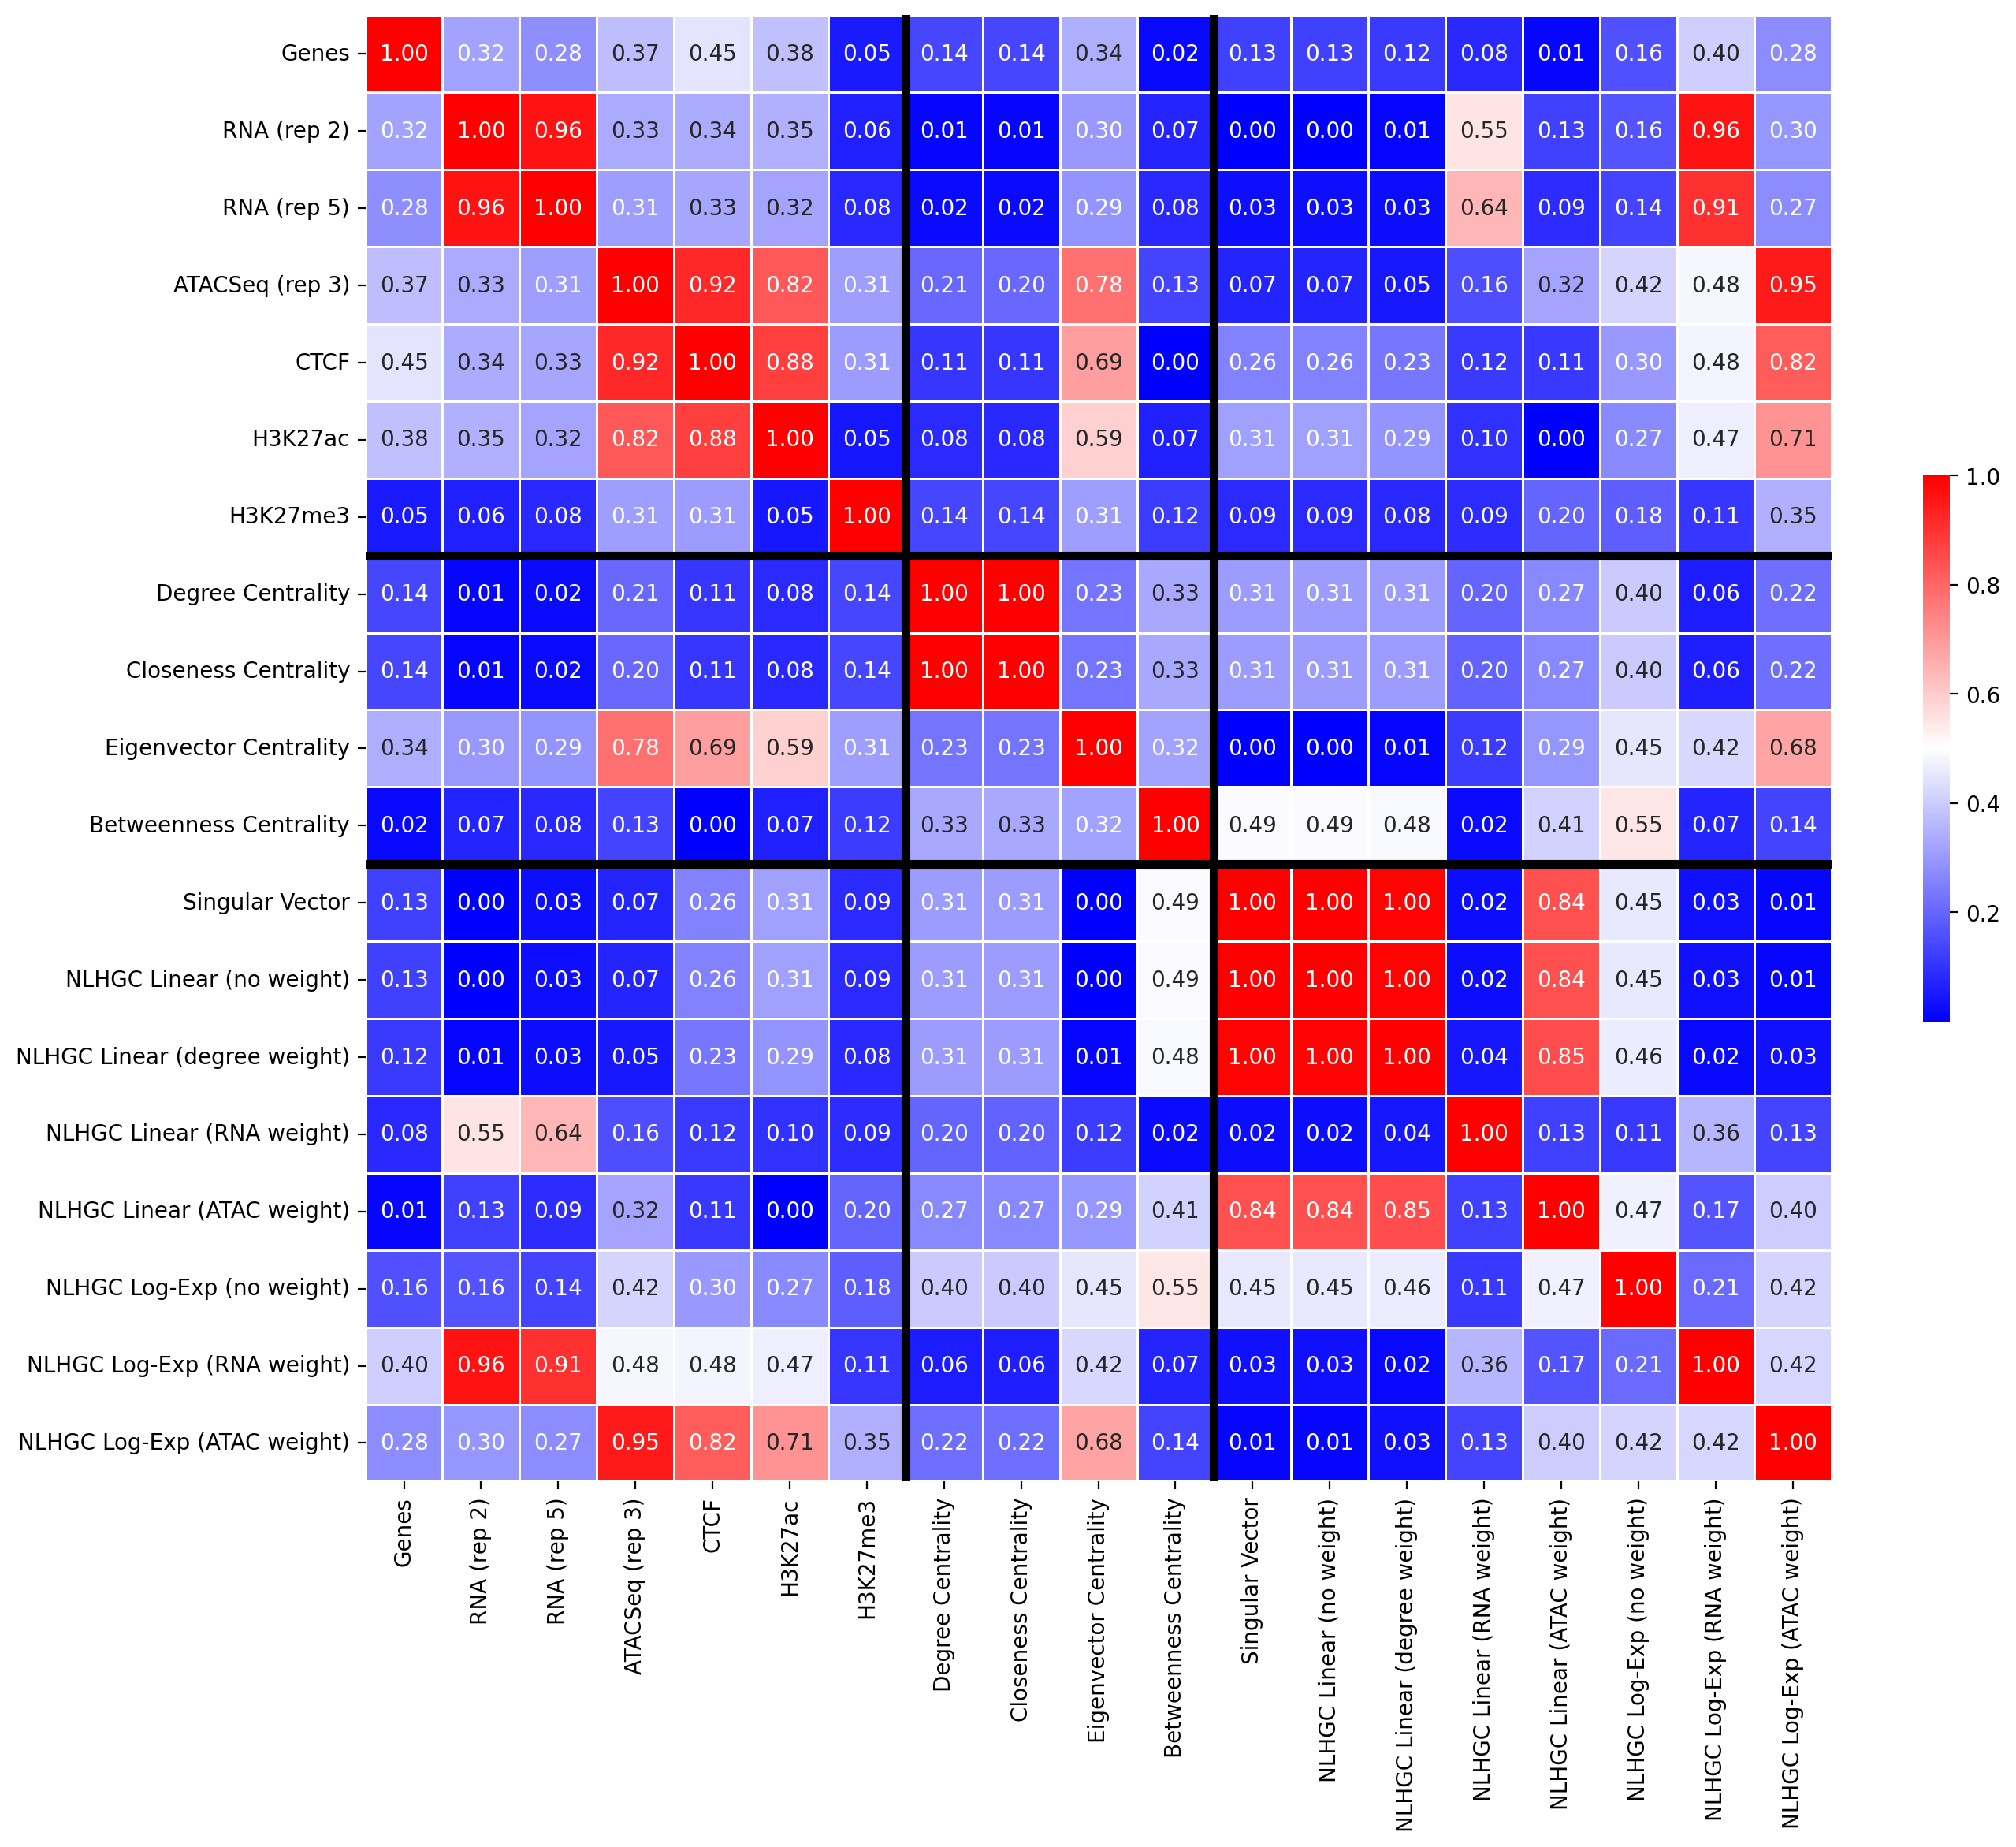

In [86]:
pdf = adata.obs.copy()

column_labels = {
    'n_genes': "Genes",
    'RNA_2': "RNA (rep 2)",
    'RNA_5': "RNA (rep 5)",
    'ATACSeq_3': "ATACSeq (rep 3)",
    'CTCF': "CTCF",
    'H3K27ac': "H3K27ac",
    'H3K27me3': "H3K27me3",
    'ce_degree_centrality': "Degree Centrality",
    'ce_closeness_centrality': "Closeness Centrality",
    'ce_eigenvector_centrality': "Eigenvector Centrality",
    'ce_betweenness_centrality': "Betweenness Centrality",
    'singular_vector_1': "Singular Vector",
    'hge_linear_unweighted' : "NLHGC Linear (no weight)",
    'hge_linear_degree_weighted' : "NLHGC Linear (degree weight)",
    'hge_linear_RNA_weighted' : "NLHGC Linear (RNA weight)",
    'hge_linear_ATAC_weighted' : "NLHGC Linear (ATAC weight)",
    'hge_logexp_unweighted' : "NLHGC Log-Exp (no weight)",
    'hge_logexp_RNA_weighted' : "NLHGC Log-Exp (RNA weight)",
    'hge_logexp_ATAC_weighted' : "NLHGC Log-Exp (ATAC weight)",
}

corr = pdf[list(column_labels.keys())].corr()
corr.index = list(column_labels.values())
corr.columns = list(column_labels.values())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 15

sns.heatmap(
    corr.abs(), 
    square=True,
    linewidths=1,
    cmap='bwr',
    annot=True,
    fmt=".2f",  # Format to show only 3 decimal places
    cbar_kws={'shrink': 0.3}
)

# Get the positions of the lines
# These positions are based on the order of your `column_labels`
lines = [7, 11,]

# Add vertical lines
for line in lines:
    plt.axvline(line, color='black', lw=4)
    plt.axhline(line, color='black', lw=4)


plt.show()

# Clustering Nodes

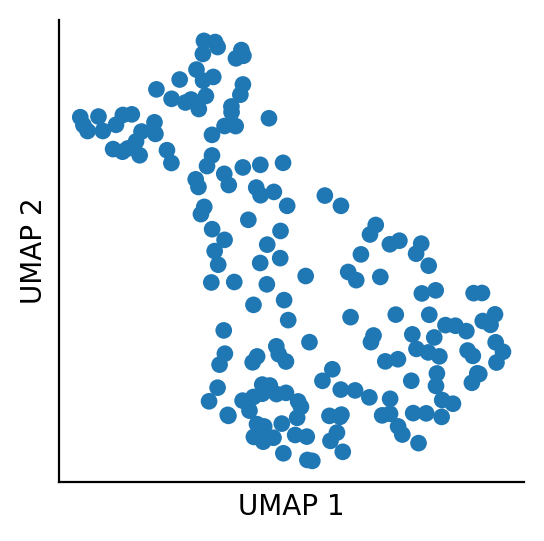

In [87]:
sc.pp.neighbors(
    adata, 
    use_rep='A_oe',
    n_neighbors=15,
)

sc.tl.umap(
    adata,
    min_dist=0.15,
)

adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.scatterplot(
    data=adata.obs,
    x='UMAP 1',
    y='UMAP 2',
    ec='none',
)

plt.yticks([])
plt.xticks([])
sns.despine()

In [88]:
df = adata.obs.copy()
df.head()

,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,hge_linear_degree_weighted,hge_linear_RNA_weighted,hge_linear_ATAC_weighted,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,UMAP 1,UMAP 2,singular_vector_1
bin_name,,,,,,,,,,,,,,,,,,,,,
chr2:3,1456,3000000,4000000,199,2,3,3532,Rpp38;Suv39h2;Fam107b;Gm37525;Gm13182;Msantd7;...,23,0.628770,...,0.044750,0.008827,0.013792,0.736855,NaN,0.704598,0.327370,-1.782855,-0.484877,0.083466
chr2:4,2267,4000000,5000000,200,2,4,3706,Gm38348;Gm13193;Sephs1;Gm13189;Gm13179;Gm13192...,23,0.692131,...,0.068450,0.008178,0.059174,0.812908,NaN,0.681395,0.251767,-1.907668,0.768423,0.118083
chr2:5,2533,5000000,6000000,201,2,5,3913,Nudt5;4930551O13Rik;Sec61a2;Ccdc3;Dhtkd1;Gm131...,14,0.798978,...,0.078109,0.008427,0.097644,0.807414,NaN,0.815276,0.140375,-1.444149,1.262042,0.125800
chr2:6,1233,6000000,7000000,202,2,6,3469,Gm38386;Gm10115;Gm13384;Gm10855;Gm13389;Gm1339...,17,0.710963,...,0.118363,0.015340,0.111161,0.635701,NaN,0.855674,0.235597,-1.373321,-0.081445,0.191865
chr2:7,1800,7000000,8000000,203,2,7,3042,Gm13210;Gm13211;Celf2;Gm28641,4,0.479755,...,0.077264,0.012098,0.019457,0.662358,NaN,0.974224,0.487814,-1.718304,-1.834248,0.140291
